# Inference for AMSR2 network with 50 epochs

## Import

In [1]:
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os
from os.path import basename, dirname, join


import glob
import argparse
import datetime
import random
import json

from netCDF4 import Dataset
from PIL import Image
import numpy as np

import data_generator
from data_generator import HugoDataGenerator, DataGenerator_sod_f, HugoBinaryGenerator, HugoSarDataGenerator,  HugoAMRS2DataGenerator

import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.metrics import (confusion_matrix, 
                            mean_squared_error, 
                            accuracy_score,
                            precision_score,
                            recall_score)
from scipy import stats
from scipy.ndimage import distance_transform_edt, zoom
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,
                                     Flatten,
                                     Dropout,
                                     BatchNormalization, 
                                     Conv2D, 
                                     MaxPooling2D)
from tensorflow.keras.regularizers import l2
from mpl_toolkits.axes_grid1 import make_axes_locatable



os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-kq81upgc because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
def convert (array):
    """
    Do nothing for HugoDataGenerator and Datageneratorsod_f
    """
    return array
    
def ice_type(stage):
    """
    Gives back the index the concentration or 1 should be on.
    Each index corresponds to a particular ice type
    (0: Young ice; 1: First Year ice; 2: Multi year ice ; 3: Ice free).
    The values on which depends this classification are described ine the
    ASIP-v2 manual.
    Parameters
    ----------
    stage : integer
        stage of development.
    Returns
    -------
    index_ : integer
        index of the list where the value (0/1 or concentration) will be.
    """
    index_= None
    if stage in range (0, 80):
        #print('water')
        index_ = 0
    if stage in range(83, 86):
        #print('Young ice')
        index_=1
    if stage in range(86, 94):
        #print('First year ice')
        index_=2
    if stage in range(95, 98):
        #print('multiyear ice')
        index_=3
    if stage in range (80,83):
        index_ = 4
    if stage in range (98,100):
        index_ = 4
    return index_

def one_hot_continous(vector_param):
    """
    Returns the list of one-hot encoded values in terms of concentration
    corresponding to ice types based on concentration and stage of development
    of thickest, second thickest and thrid thickest ice.

    Parameters
    ----------
    vector_param : list
        all parameters in a vector.

    Returns
    -------
    result : list
        List of one-hot encoded (in terms of concentration) values
        corresponding to ice types.
    """
    vector_param = vector_param
    result = [0, 0, 0, 0, 0]
    if vector_param[0] < 10 : #it is water
        result[0] = 1
        return result[:4]
    for ice in range(3): # in a output there are 3 data for the 3 most present ice
        if vector_param[1+ice*3]==(-9):
            continue
        if vector_param[2+ice*3]==(-9):
            continue
        icetype = ice_type(vector_param[2+ice*3])

        result[icetype] += round(vector_param[1+ice*3]/100,1)
    if max(result) == 0:
        icetype = ice_type(vector_param[2])
        result[icetype] += round(vector_param[0]/100,1)
        result[0] = 1-sum(result[1:])
    else:
        result[0] = 1-sum(result[1:])
    result = convert(result)
    result = result[:4]
    return np.round(result,1)

## Load data and model

In [4]:
idir_pre = '/tf/data/hugo_continous_amsr2/output_inference_check/'
input_dir_json = '/tf/data/hugo_continous_amsr2/output_preprocessed_continous/'
idir_model = '/tf/sea_ice_type_cnn_training/asip_v2/hugo_model_continous_amsr2_bis_all50_nopatience/'

In [5]:
input_var_names = ['nersc_sar_primary', 'nersc_sar_secondary']
amsr2_var_names = [ 
    'btemp_6_9h',
                    'btemp_6_9v',
                    'btemp_7_3h',
                    'btemp_7_3v',
                    'btemp_10_7h',
                    'btemp_10_7v',
                    'btemp_18_7h',
                    'btemp_18_7v',
                    'btemp_23_8h',
                    'btemp_23_8v',
                    'btemp_36_5h',
                    'btemp_36_5v',
                    'btemp_89_0h',
                    'btemp_89_0v'
                  ]
 
output_var_name = 'ice_type'


params = {'idir_json':       input_dir_json,
          'output_var_name': output_var_name,
          'input_var_names': input_var_names,
          'amsr2_var_names': amsr2_var_names,
          'batch_size':      50,
          'shuffle_on_epoch_end': False,
           }

In [6]:
modelbis = keras.models.load_model(idir_model)

## Built maps

In [7]:
all_img=[]

with open(f'{idir_pre}processed_files.json') as fichier_json:
    all_nc = json.load(fichier_json)

for nc in all_nc[:]:
    
    #nc
    print(nc)
    nc_ifile =f'/Data/{nc}'
    ds_nc = Dataset(nc_ifile, format="NETCDF4")
    
    #sar image
    nersc_sar_primary = ds_nc['nersc_sar_primary'][:]
    gpi = np.isfinite(nersc_sar_primary)
    clim = np.percentile(nersc_sar_primary[gpi], [1,99])
    nersc_sar_primary_uint8 = np.clip(255*(nersc_sar_primary - clim[0]) / (clim[1] - clim[0]).astype(np.uint8), 0, 255)
    img_sar = Image.fromarray(nersc_sar_primary_uint8[::10, ::10]).convert('RGBA')
    ic = ds_nc['polygon_icechart'][:].astype('float32').filled(0)
    n, p = ic.shape #shape of image
    
    
    name = nc[:15]
    check_files = sorted(glob.glob(f'{idir_pre}/{name}/*.npz'))  
    print(len(check_files))
    
    dims_amsr2 = np.load(check_files[0])[amsr2_var_names[0]].shape
    dict_temp = {'dims_amsr2': (*dims_amsr2, len(amsr2_var_names))}
    params.update(dict_temp)
    
    check_generator = HugoAMRS2DataGenerator(check_files, **params)
    y_pred = modelbis.predict(check_generator)
    
    
    
   
    
    y_val = []
    all_loc=[]
    for npz_file in check_files[:(len(check_files)//50)*50] :
        loc = np.load(npz_file).get("loc")
        vector_param = list(np.load(npz_file).get("ice_type"))
        vector_binary = one_hot_continous(vector_param)
        y_val.append(list(vector_binary))
        all_loc.append(list(loc))
    y_val=np.array(y_val)
    images_classes =[]
    for id_class in range(y_pred.shape[1]):
        classes_pred = y_pred[:,id_class]
        classes_val = y_val[:,id_class]    
    #     build the map
        img_val = np.zeros((n//50, p//50))*np.nan
        img_pre = np.zeros((n//50, p//50))*np.nan
        img_dif = np.zeros ((n//50, p//50))*np.nan
        for i in range (n//50):
            for j in range (p//50):
                pos = [i,j]
                if pos in all_loc :
                    index = all_loc.index(pos)
                    img_val [i][j] = classes_val[index]
                    img_pre [i][j] = classes_pred[index]
                    img_dif [i][j] = (classes_pred[index]-classes_val[index])
        img_val = zoom(img_val, 5, order=0)
        img_pre = zoom(img_pre, 5, order=0)
        img_dif = zoom(img_dif, 5, order=0)
        images_classes.append([img_val, img_pre, img_dif])


    all_img.append([img_sar, images_classes])
    
    
    
    

20190509T081206_S1A_AMSR2_Icechart-Greenland-CentralEast.nc


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


20693
413/413 [==============================] - 131s 314ms/step
20190208T081200_S1B_AMSR2_Icechart-Greenland-CentralEast.nc
27520
550/550 [==============================] - 175s 318ms/step
20190110T183531_S1A_AMSR2_Icechart-Greenland-CentralEast.nc
35954
719/719 [==============================] - 224s 311ms/step
20180818T085755_S1B_AMSR2_Icechart-Greenland-NorthEast.nc
28279
565/565 [==============================] - 179s 316ms/step
20190509T081306_S1A_AMSR2_Icechart-Greenland-CentralEast.nc
28541
570/570 [==============================] - 176s 309ms/step


## Show results

20190509T081206_S1A_AMSR2_Icechart-Greenland-CentralEast.nc


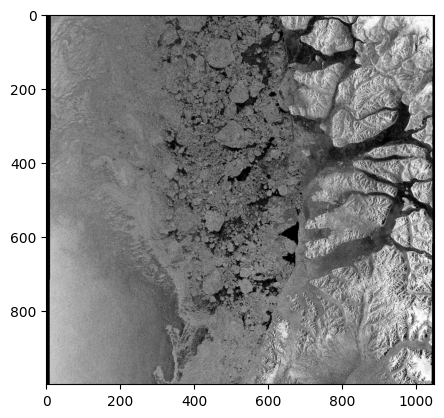

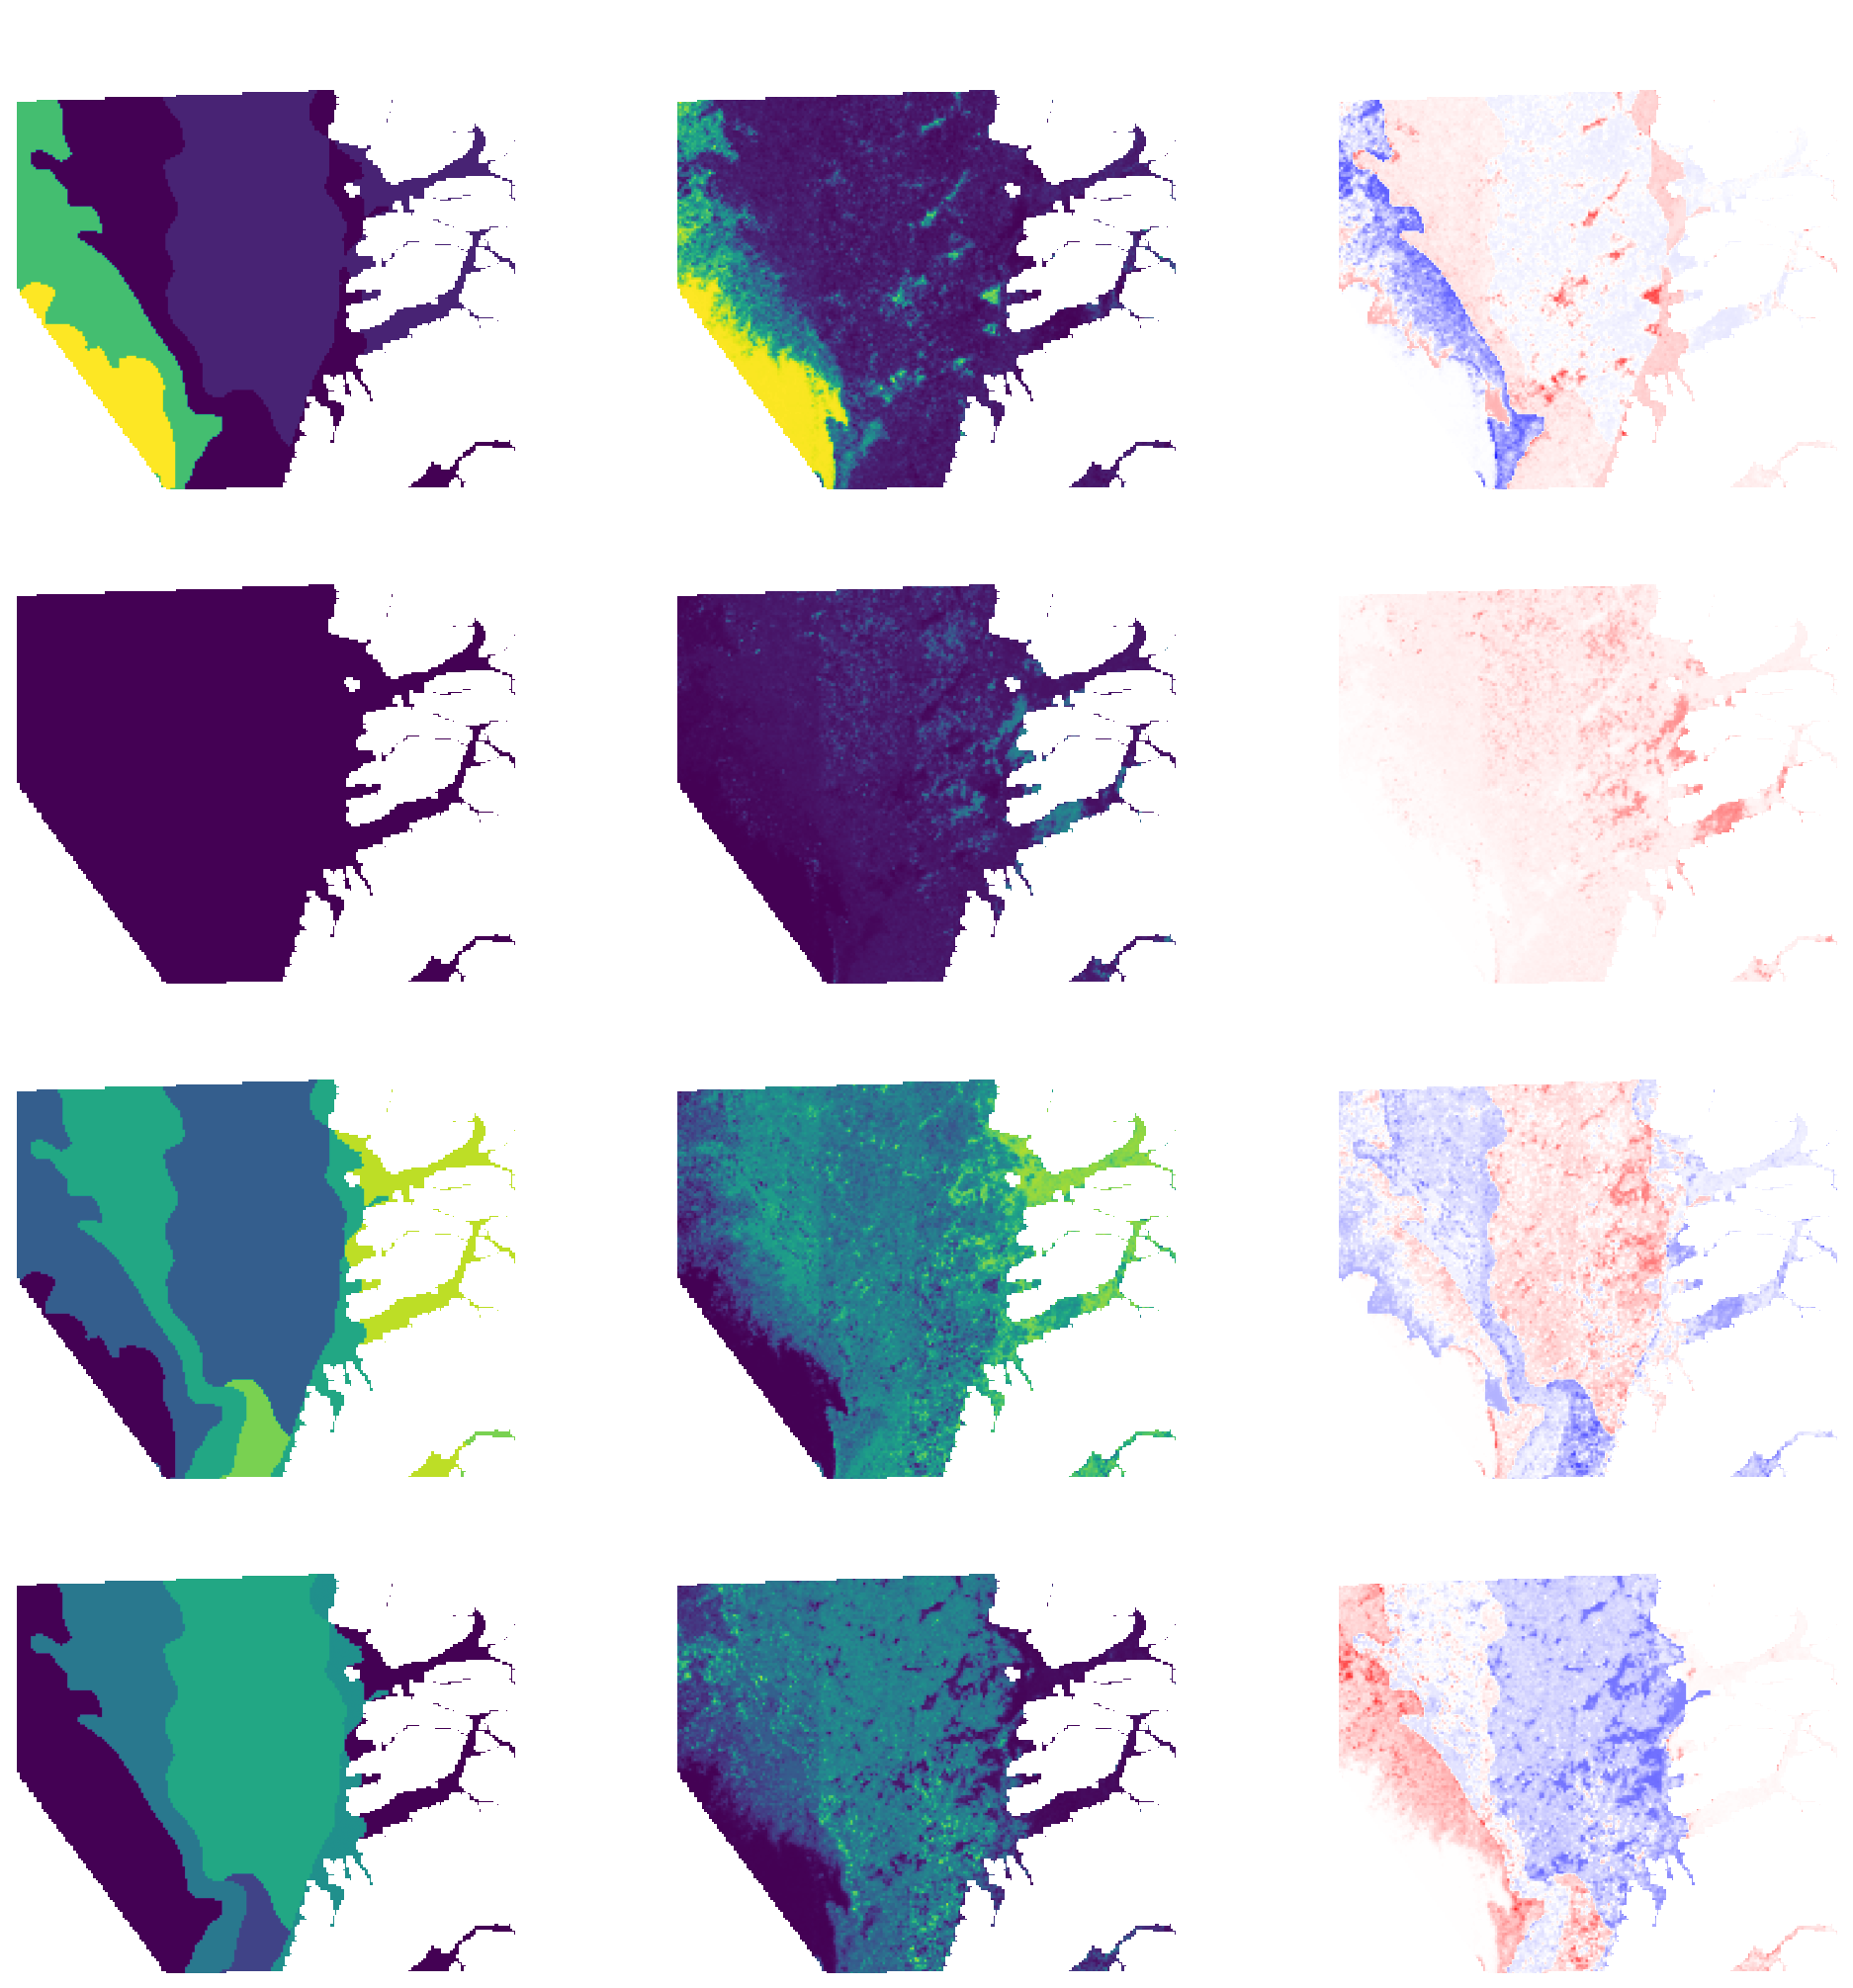

20190208T081200_S1B_AMSR2_Icechart-Greenland-CentralEast.nc


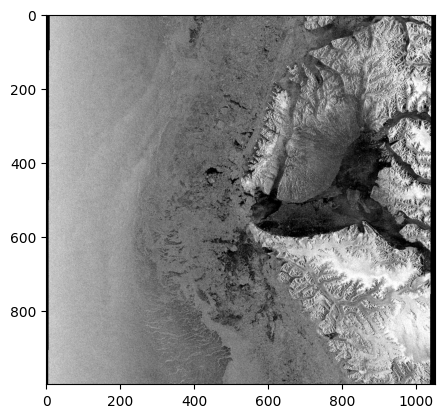

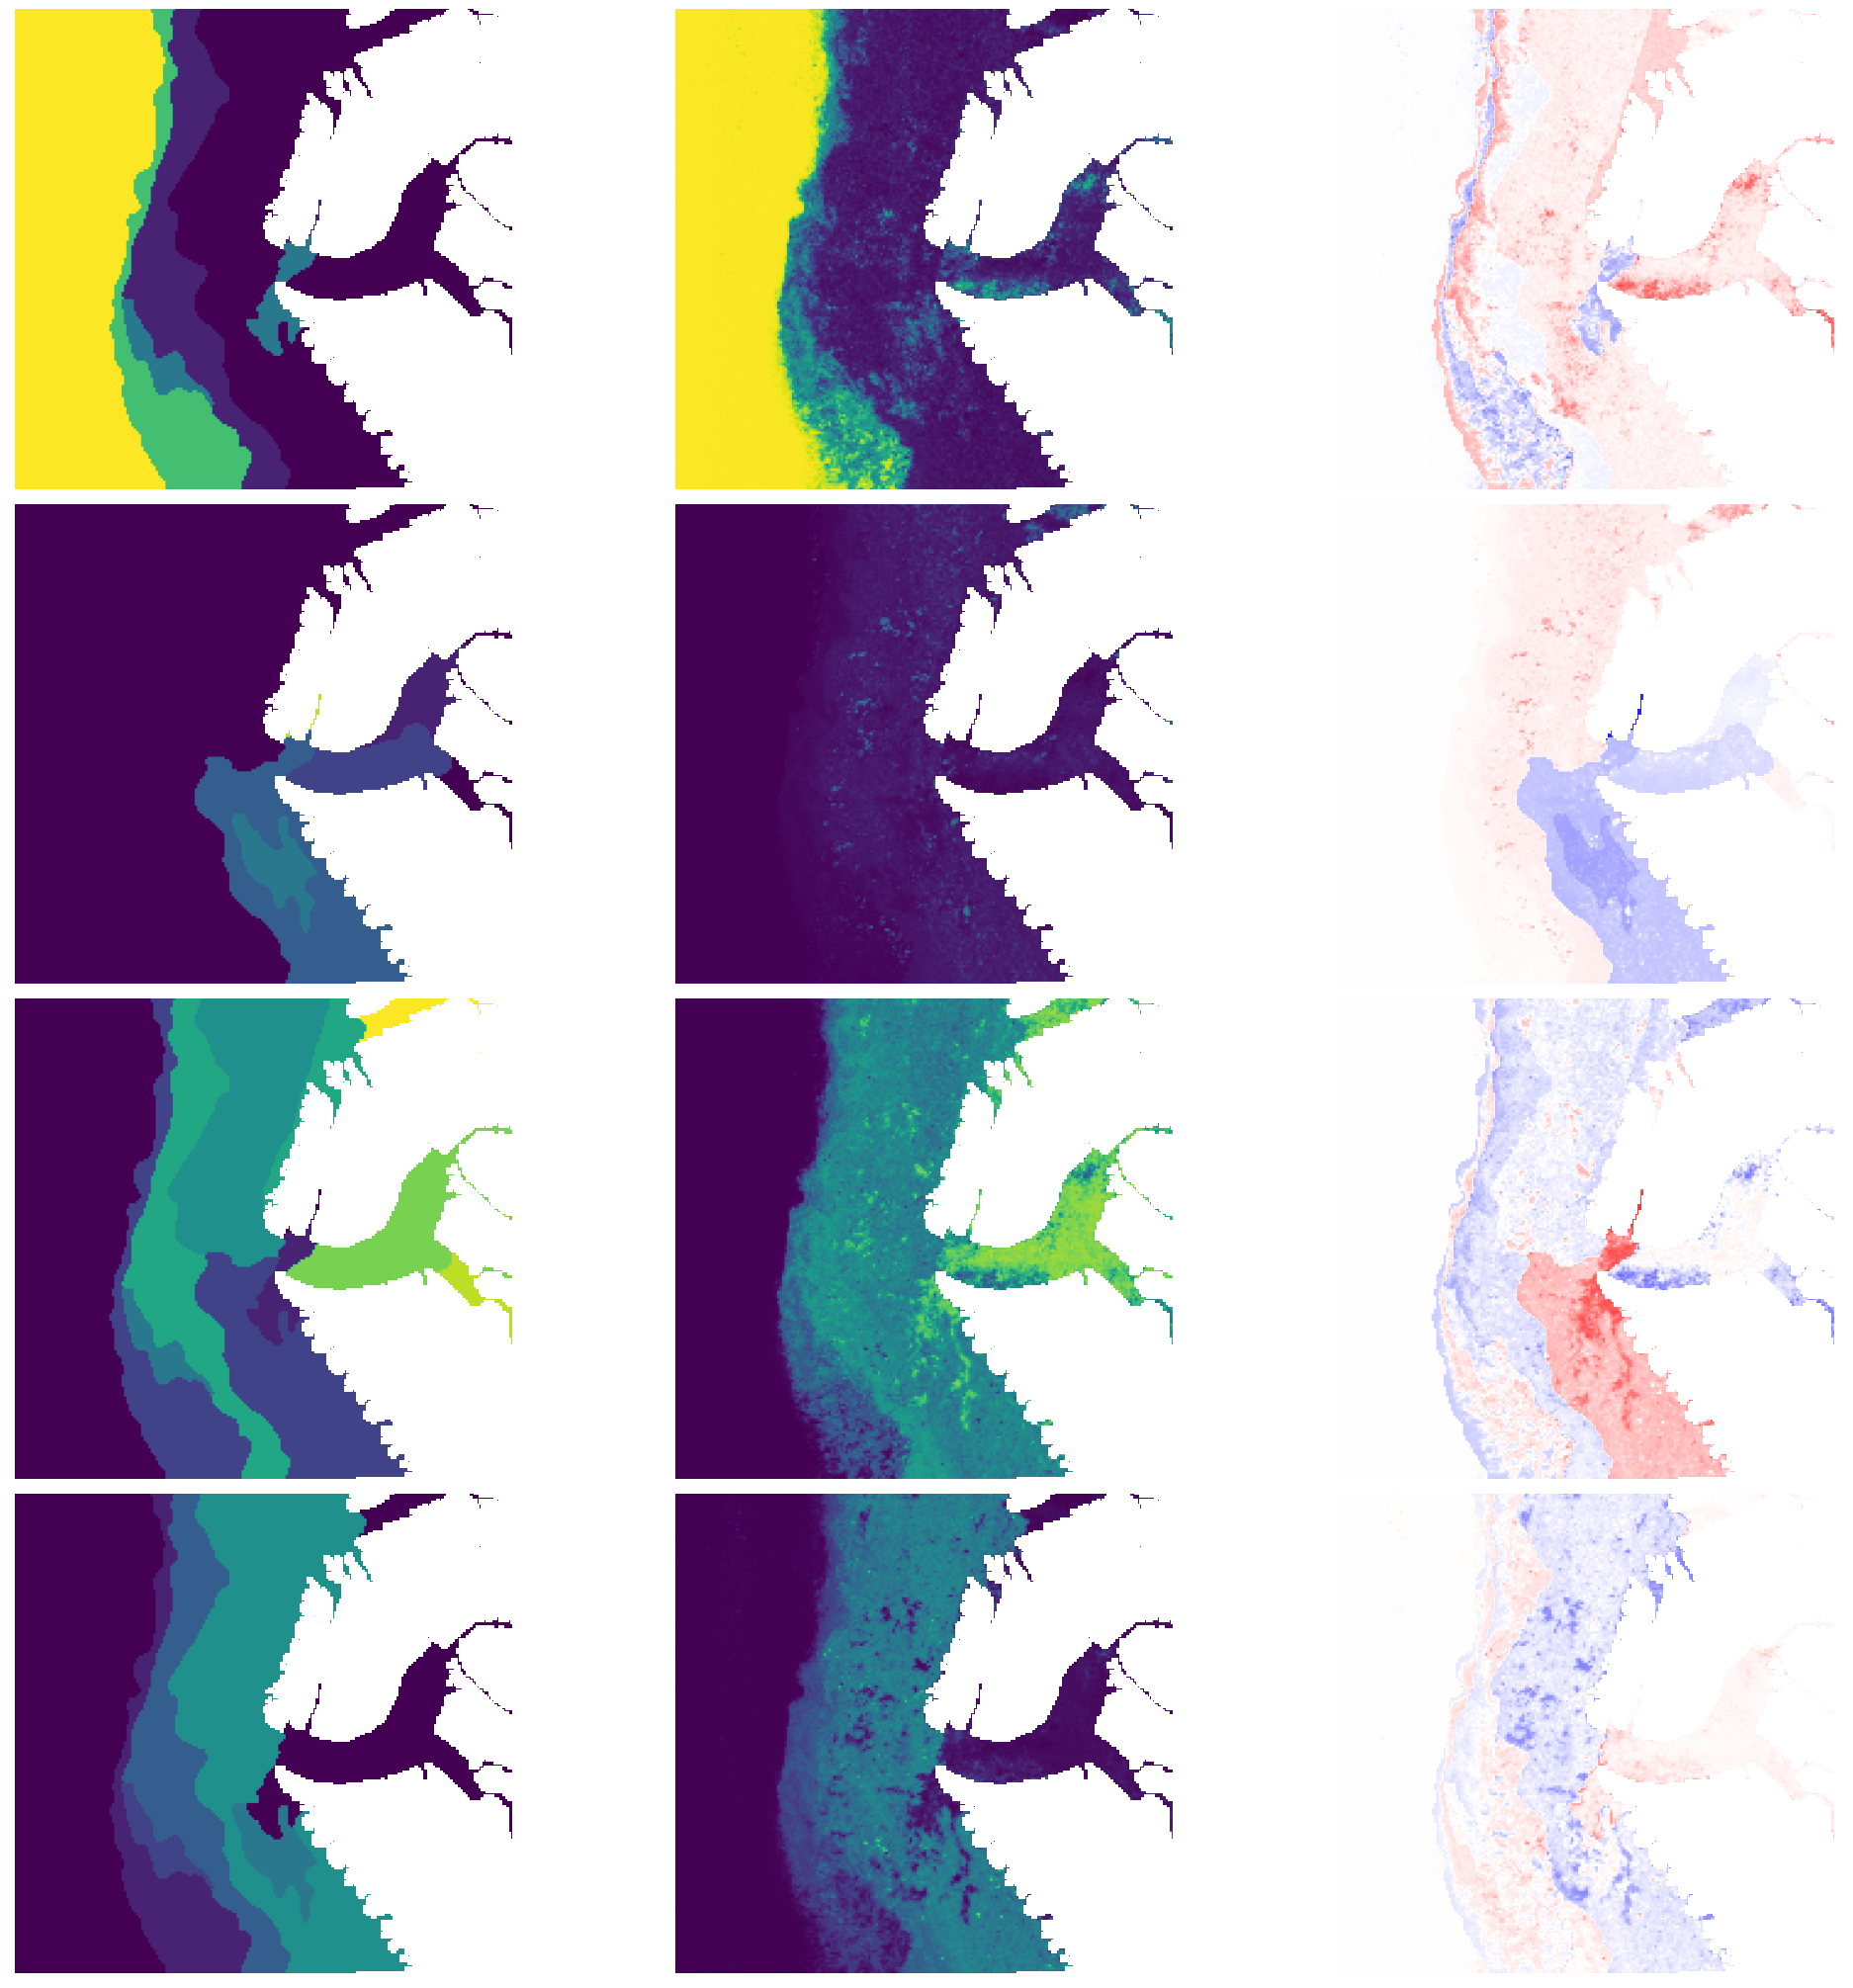

20190110T183531_S1A_AMSR2_Icechart-Greenland-CentralEast.nc


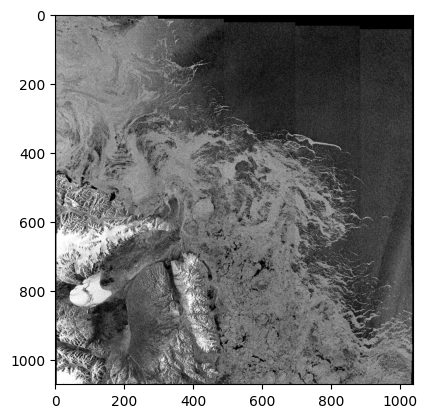

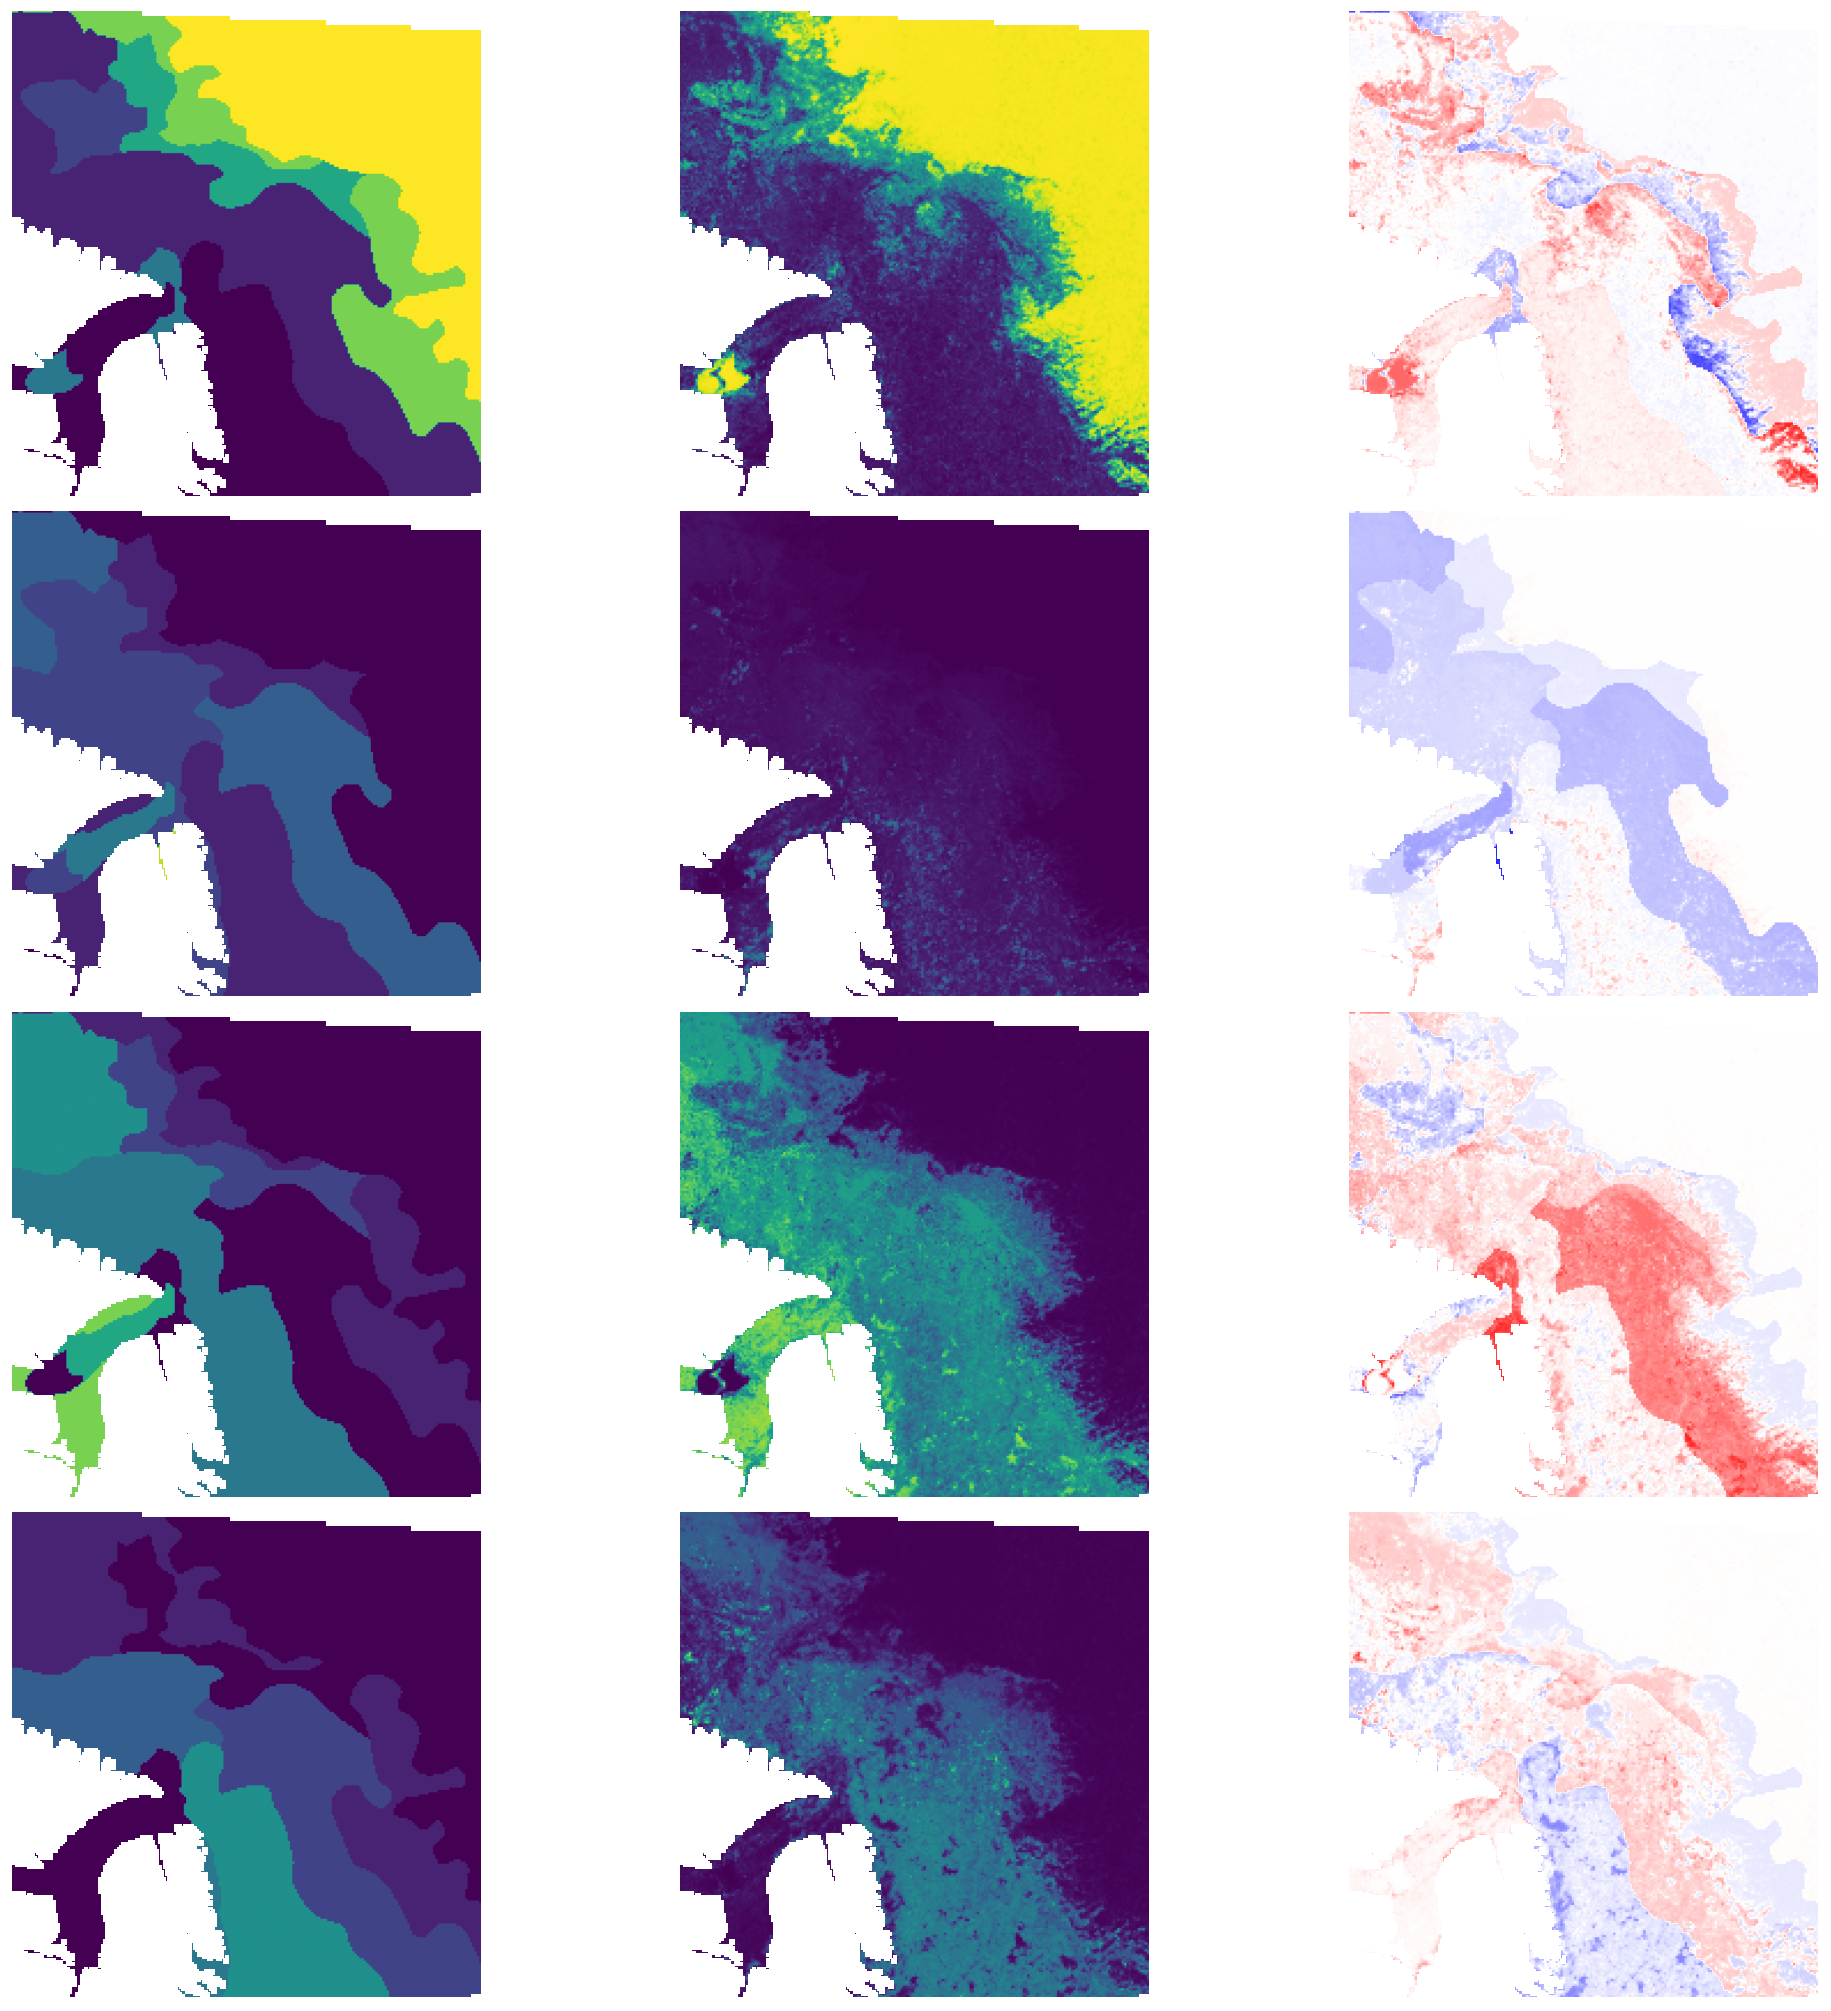

20180818T085755_S1B_AMSR2_Icechart-Greenland-NorthEast.nc


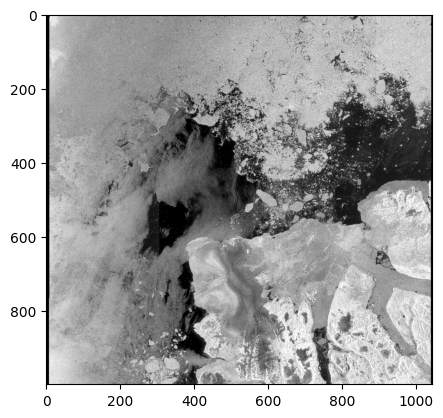

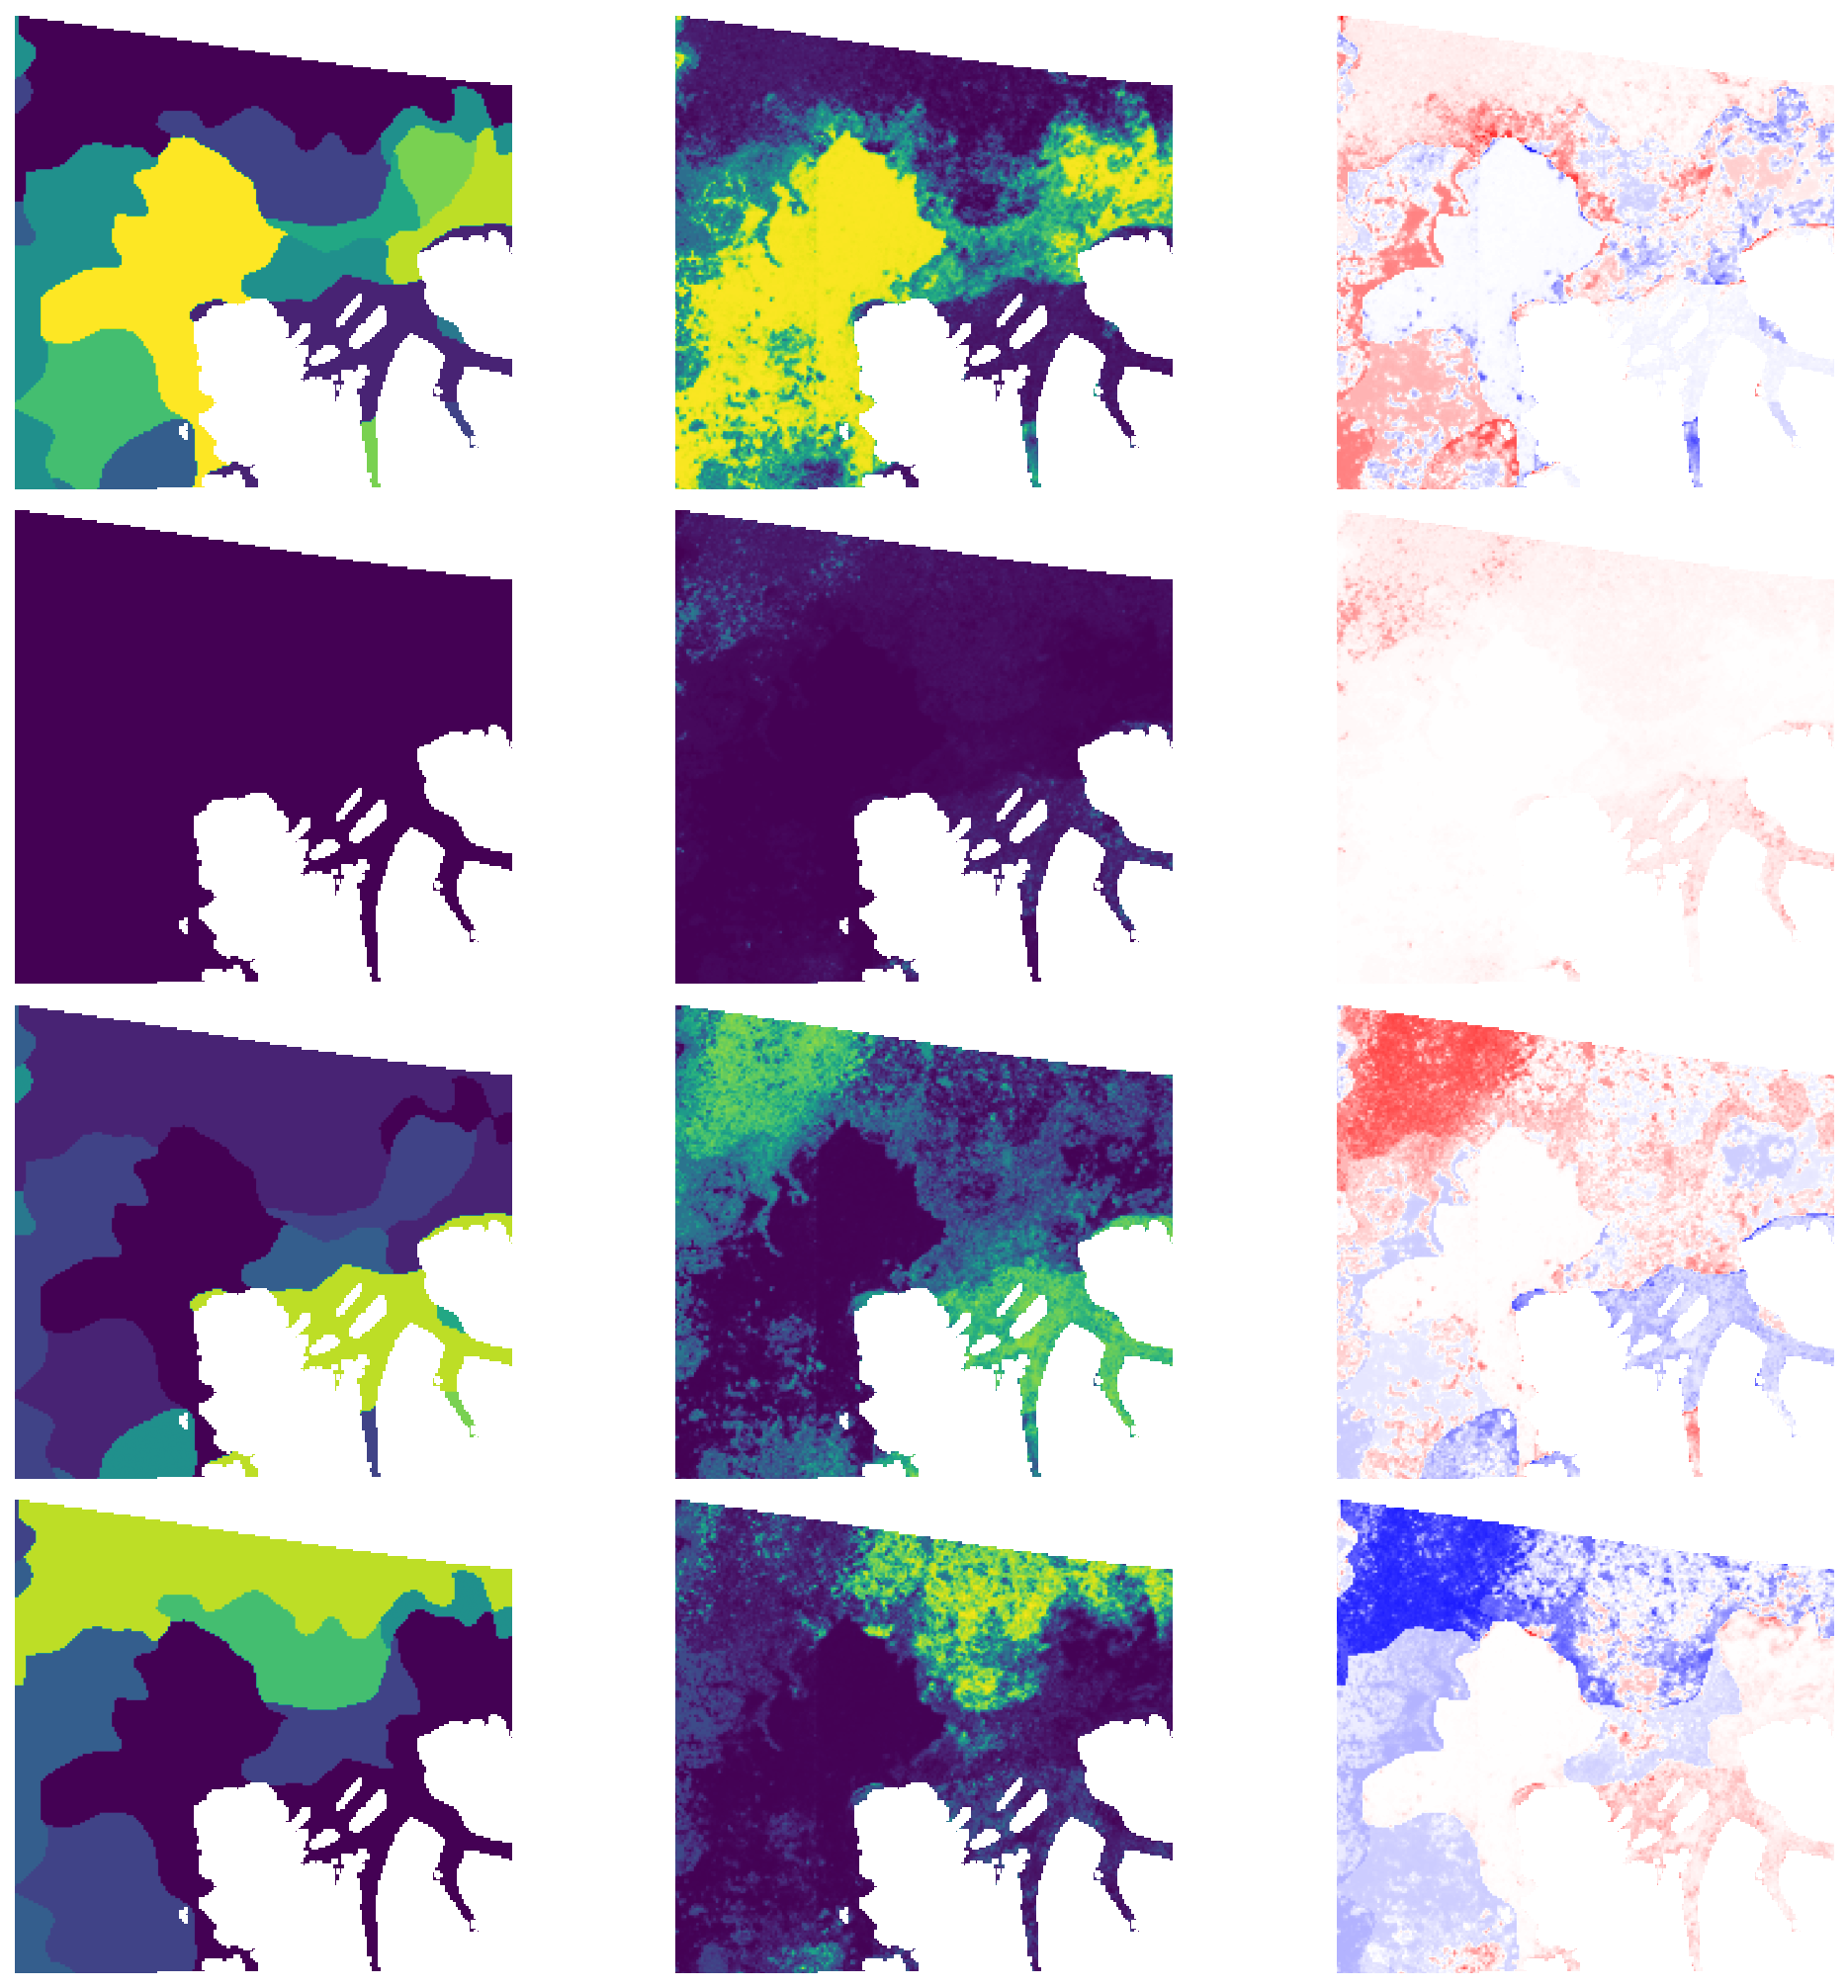

20190509T081306_S1A_AMSR2_Icechart-Greenland-CentralEast.nc


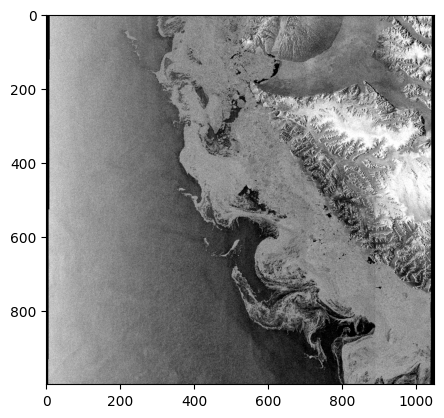

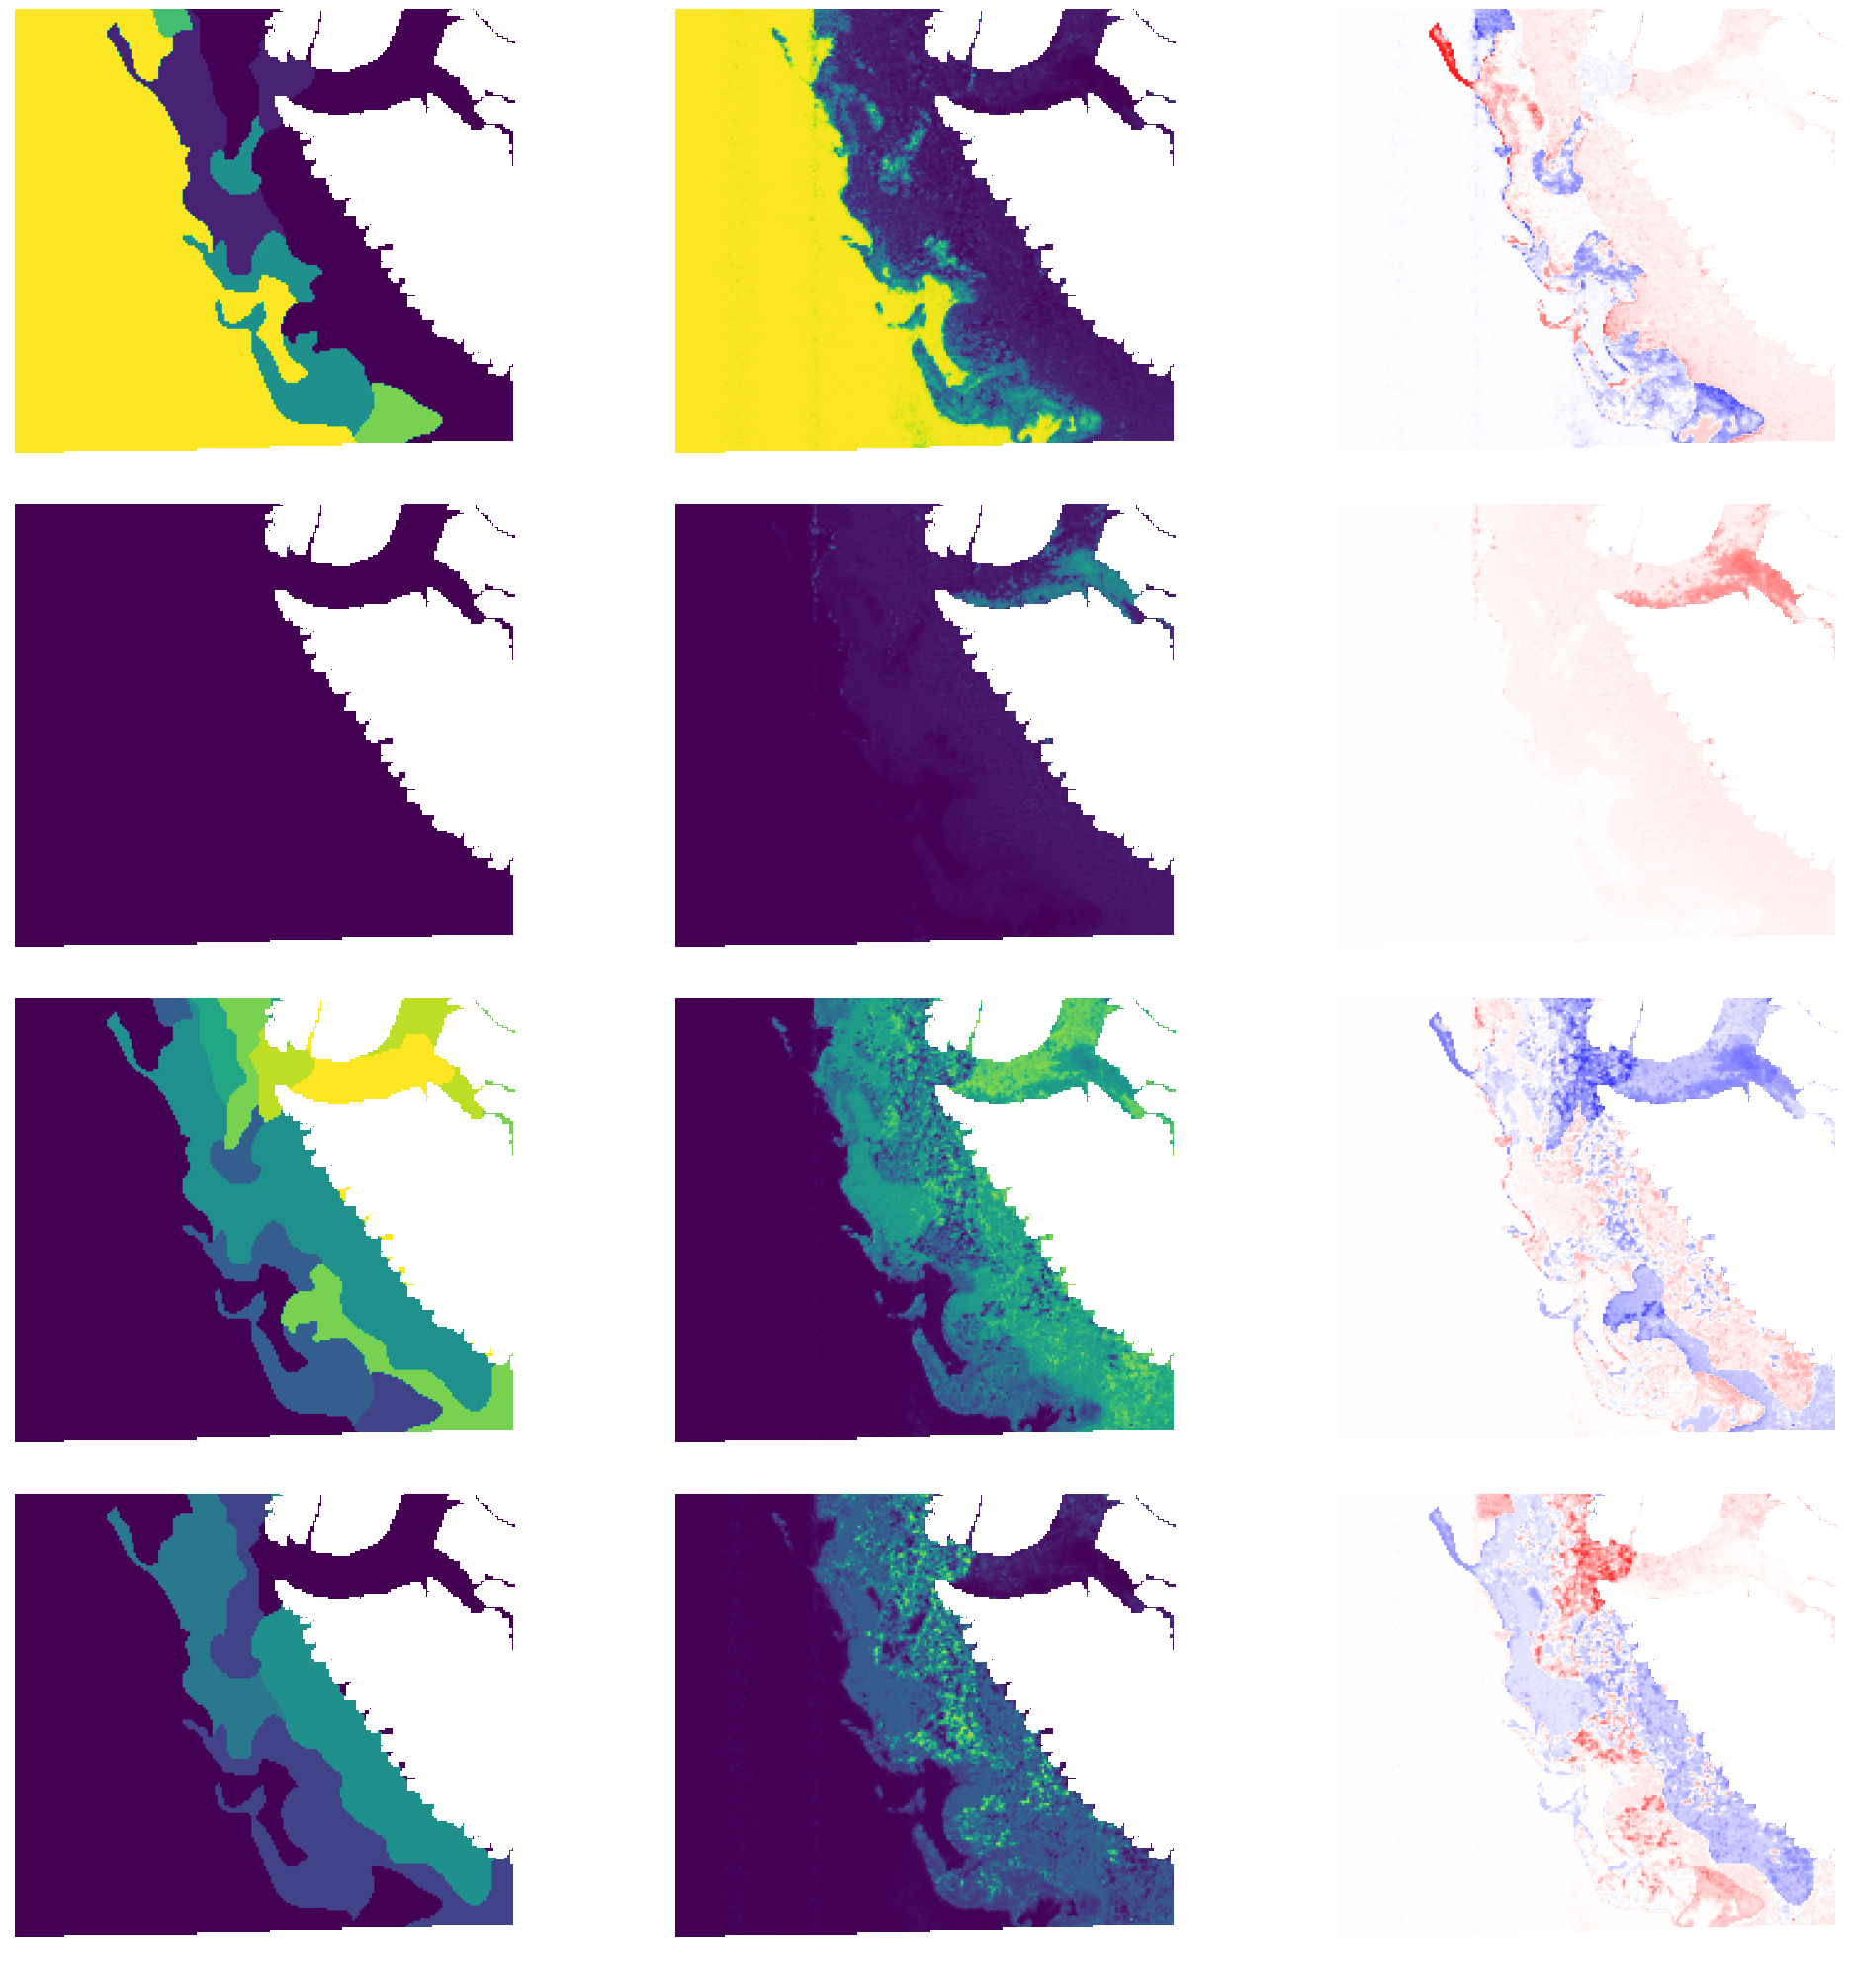

In [8]:
for combo, nc in zip(all_img, all_nc) :
    print(nc)
    plt.clf
    plt.imshow(combo[0])
    fig, ax = plt.subplots(4, 3, constrained_layout=True)
    
    for i in range (4):
        im1 = ax[i][0].imshow(combo[1][i][0], clim=[0,1])
        ax[i][0].axis('off')
        im2 = ax[i][1].imshow(combo[1][i][1], clim=[0,1]) 
        ax[i][1].axis('off')
        im3 = ax[i][2].imshow(combo[1][i][2], cmap='bwr', clim=[-1,1])
        ax[i][2].axis('off')
    fig.set_size_inches(20, 20)

    plt.show()